In [1]:
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
!nvidia-smi

Sun Feb 18 20:46:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   35C    P8              19W / 215W |    316MiB /  8192MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = '../data/physionet/fold4/'

cuda


In [6]:
sr = 16000

x_train = np.load(f'{data_dir}heartsound.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}heartsound.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}heartsound.labels_binary.test.npy', allow_pickle=True)

In [8]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=False, 
                              batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, 
                             batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [9]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [12]:
from IConNet.nn.model import M13
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m13.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M13(config=model_config,
           n_input=1, n_output=2)
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M13
description: FirConv with fftconv
fe:
  n_block: 2
  n_channel:
  - 128
  - 32
  kernel_size:
  - 511
  - 127
  stride:
  - 8
  - 2
  window_k:
  - 2
  - 9
  residual_connection_type: stack
  pooling: mean
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer)

In [13]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [14]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    # print(f'Mem before training: {torch.cuda.memory_allocated()}')
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data_length} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [15]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                        | 0.002061855670103093/10 [00:00<1:02:57, 377.82s/it]

Train Epoch: 1 [0/11481 (0%)]	Loss: 0.407902
Mem before-during-after: 633344 4366444544 33845760


  1%|▋                                                                          | 0.08453608247422686/10 [00:17<34:30, 208.79s/it]

Train Epoch: 1 [1280/11481 (11%)]	Loss: 0.282500
Mem before-during-after: 33698304 4376186880 33812992


  2%|█▎                                                                         | 0.16701030927835056/10 [00:34<34:15, 209.03s/it]

Train Epoch: 1 [2560/11481 (22%)]	Loss: 0.665909
Mem before-during-after: 33698304 4376186880 33812992


  2%|█▊                                                                         | 0.24948453608247398/10 [00:51<34:18, 211.09s/it]

Train Epoch: 1 [3840/11481 (34%)]	Loss: 0.163518
Mem before-during-after: 33698304 4376186880 33812992


  3%|██▌                                                                         | 0.3319587628865974/10 [01:09<34:42, 215.38s/it]

Train Epoch: 1 [5120/11481 (45%)]	Loss: 0.548327
Mem before-during-after: 33698304 4376186880 33812992


  4%|███                                                                        | 0.41443298969072084/10 [01:26<38:34, 241.46s/it]

Train Epoch: 1 [6400/11481 (56%)]	Loss: 0.522410
Mem before-during-after: 33698304 4376186880 33812992


  5%|███▋                                                                       | 0.49690721649484426/10 [01:44<33:37, 212.35s/it]

Train Epoch: 1 [7680/11481 (67%)]	Loss: 0.562714
Mem before-during-after: 33698304 4376186880 33812992


  6%|████▍                                                                       | 0.5793814432989677/10 [02:02<34:16, 218.32s/it]

Train Epoch: 1 [8960/11481 (78%)]	Loss: 0.309714
Mem before-during-after: 33698304 4376186880 33812992


  7%|█████                                                                       | 0.6618556701030911/10 [02:19<32:47, 210.70s/it]

Train Epoch: 1 [10240/11481 (89%)]	Loss: 0.722750
Mem before-during-after: 33698304 4376186880 33812992


 10%|███████▌                                                                    | 0.9999999999999971/10 [03:02<15:39, 104.38s/it]


Test Epoch: 1	Accuracy: 3094/4064 (76%)



 10%|███████▌                                                                    | 1.0020618556701002/10 [03:02<19:49, 132.20s/it]

Train Epoch: 2 [0/11481 (0%)]	Loss: 0.268297
Mem before-during-after: 33658368 4377006592 33665536


 11%|████████▏                                                                   | 1.0845360824742236/10 [03:19<31:22, 211.10s/it]

Train Epoch: 2 [1280/11481 (11%)]	Loss: 0.330110
Mem before-during-after: 33665536 4377096704 33665536


 12%|████████▉                                                                    | 1.167010309278347/10 [03:36<30:29, 207.17s/it]

Train Epoch: 2 [2560/11481 (22%)]	Loss: 0.540267
Mem before-during-after: 33665536 4377096704 33665536


 12%|█████████▍                                                                  | 1.2494845360824705/10 [03:52<30:07, 206.53s/it]

Train Epoch: 2 [3840/11481 (34%)]	Loss: 0.172106
Mem before-during-after: 33665536 4377096704 33665536


 13%|██████████                                                                  | 1.3319587628865939/10 [04:09<29:49, 206.42s/it]

Train Epoch: 2 [5120/11481 (45%)]	Loss: 0.965617
Mem before-during-after: 33665536 4377096704 33665536


 14%|██████████▋                                                                 | 1.4144329896907173/10 [04:26<30:02, 209.93s/it]

Train Epoch: 2 [6400/11481 (56%)]	Loss: 0.273002
Mem before-during-after: 33665536 4377096704 33665536


 15%|███████████▍                                                                | 1.4969072164948407/10 [04:43<29:34, 208.69s/it]

Train Epoch: 2 [7680/11481 (67%)]	Loss: 0.400831
Mem before-during-after: 33665536 4377096704 33665536


 16%|████████████                                                                | 1.5793814432989641/10 [05:00<29:40, 211.43s/it]

Train Epoch: 2 [8960/11481 (78%)]	Loss: 0.264163
Mem before-during-after: 33665536 4377096704 33665536


 17%|████████████▋                                                               | 1.6618556701030875/10 [05:16<28:32, 205.34s/it]

Train Epoch: 2 [10240/11481 (89%)]	Loss: 0.607640
Mem before-during-after: 33665536 4377096704 33665536


 20%|███████████████▏                                                            | 1.9999999999999936/10 [05:59<13:37, 102.20s/it]


Test Epoch: 2	Accuracy: 3343/4064 (82%)



 20%|███████████████▍                                                             | 2.002061855670097/10 [05:59<17:15, 129.42s/it]

Train Epoch: 3 [0/11481 (0%)]	Loss: 0.136114
Mem before-during-after: 33658368 4377022976 33665536


 21%|███████████████▊                                                            | 2.0845360824742203/10 [06:16<27:22, 207.50s/it]

Train Epoch: 3 [1280/11481 (11%)]	Loss: 0.010581
Mem before-during-after: 33681920 4376540160 33681920


 22%|████████████████▍                                                           | 2.1670103092783437/10 [06:33<27:04, 207.39s/it]

Train Epoch: 3 [2560/11481 (22%)]	Loss: 0.431223
Mem before-during-after: 33681920 4376540160 33681920


 22%|█████████████████▎                                                           | 2.249484536082467/10 [06:49<26:34, 205.76s/it]

Train Epoch: 3 [3840/11481 (34%)]	Loss: 0.048061
Mem before-during-after: 33681920 4376540160 33681920


 23%|█████████████████▋                                                          | 2.3319587628865905/10 [07:06<26:49, 209.93s/it]

Train Epoch: 3 [5120/11481 (45%)]	Loss: 0.806554
Mem before-during-after: 33681920 4376540160 33681920


 24%|██████████████████▌                                                          | 2.414432989690714/10 [07:23<26:10, 207.07s/it]

Train Epoch: 3 [6400/11481 (56%)]	Loss: 0.283707
Mem before-during-after: 33681920 4376540160 33681920


 25%|██████████████████▉                                                         | 2.4969072164948374/10 [07:40<26:05, 208.63s/it]

Train Epoch: 3 [7680/11481 (67%)]	Loss: 0.408666
Mem before-during-after: 33681920 4376540160 33681920


 26%|███████████████████▊                                                         | 2.579381443298961/10 [07:56<26:00, 210.28s/it]

Train Epoch: 3 [8960/11481 (78%)]	Loss: 0.177572
Mem before-during-after: 33681920 4376540160 33681920


 27%|████████████████████▍                                                        | 2.661855670103084/10 [08:13<25:08, 205.56s/it]

Train Epoch: 3 [10240/11481 (89%)]	Loss: 0.340132
Mem before-during-after: 33681920 4376540160 33681920


 30%|██████████████████████▊                                                     | 2.9999999999999902/10 [08:55<11:59, 102.76s/it]


Test Epoch: 3	Accuracy: 3302/4064 (81%)



 30%|██████████████████████▊                                                     | 3.0020618556700933/10 [08:56<15:26, 132.47s/it]

Train Epoch: 4 [0/11481 (0%)]	Loss: 0.094212
Mem before-during-after: 33658368 4377088512 34599936


 31%|███████████████████████▍                                                    | 3.0845360824742167/10 [09:12<23:39, 205.29s/it]

Train Epoch: 4 [1280/11481 (11%)]	Loss: 0.216642
Mem before-during-after: 33681920 4376908800 33681920


 32%|████████████████████████▋                                                     | 3.16701030927834/10 [09:29<23:46, 208.76s/it]

Train Epoch: 4 [2560/11481 (22%)]	Loss: 0.412636
Mem before-during-after: 33681920 4376908800 33681920


 32%|████████████████████████▋                                                   | 3.2494845360824636/10 [09:46<23:01, 204.65s/it]

Train Epoch: 4 [3840/11481 (34%)]	Loss: 0.045202
Mem before-during-after: 33681920 4376908800 33681920


 33%|█████████████████████████▋                                                   | 3.331958762886587/10 [10:02<23:19, 209.88s/it]

Train Epoch: 4 [5120/11481 (45%)]	Loss: 0.834037
Mem before-during-after: 33681920 4376908800 33681920


 34%|█████████████████████████▉                                                  | 3.4144329896907104/10 [10:19<22:31, 205.17s/it]

Train Epoch: 4 [6400/11481 (56%)]	Loss: 0.298427
Mem before-during-after: 33681920 4376908800 33681920


 35%|██████████████████████████▉                                                  | 3.496907216494834/10 [10:36<22:33, 208.08s/it]

Train Epoch: 4 [7680/11481 (67%)]	Loss: 0.356180
Mem before-during-after: 33681920 4376908800 33681920


 36%|███████████████████████████▏                                                | 3.5793814432989572/10 [10:52<21:59, 205.53s/it]

Train Epoch: 4 [8960/11481 (78%)]	Loss: 0.142090
Mem before-during-after: 33681920 4376908800 33681920


 37%|███████████████████████████▊                                                | 3.6618556701030807/10 [11:09<21:48, 206.47s/it]

Train Epoch: 4 [10240/11481 (89%)]	Loss: 0.525974
Mem before-during-after: 33681920 4376908800 33681920


 40%|██████████████████████████████▍                                             | 3.9999999999999867/10 [11:52<10:14, 102.44s/it]


Test Epoch: 4	Accuracy: 3420/4064 (84%)



 40%|███████████████████████████████▏                                              | 4.00206185567009/10 [11:52<12:56, 129.44s/it]

Train Epoch: 5 [0/11481 (0%)]	Loss: 0.039522
Mem before-during-after: 33658368 4377088512 34599936


 41%|███████████████████████████████▍                                             | 4.084536082474213/10 [12:09<20:22, 206.58s/it]

Train Epoch: 5 [1280/11481 (11%)]	Loss: 0.053281
Mem before-during-after: 33681920 4376908800 33681920


 42%|████████████████████████████████                                             | 4.167010309278337/10 [12:25<20:33, 211.49s/it]

Train Epoch: 5 [2560/11481 (22%)]	Loss: 0.414001
Mem before-during-after: 33681920 4376908800 33681920


 42%|█████████████████████████████████▏                                            | 4.24948453608246/10 [12:42<20:09, 210.39s/it]

Train Epoch: 5 [3840/11481 (34%)]	Loss: 0.048895
Mem before-during-after: 33681920 4376908800 33681920


 43%|█████████████████████████████████▎                                           | 4.331958762886583/10 [13:00<20:50, 220.70s/it]

Train Epoch: 5 [5120/11481 (45%)]	Loss: 0.815470
Mem before-during-after: 33681920 4376908800 33681920


 44%|█████████████████████████████████▉                                           | 4.414432989690707/10 [13:18<20:32, 220.67s/it]

Train Epoch: 5 [6400/11481 (56%)]	Loss: 0.300061
Mem before-during-after: 33681920 4376908800 33681920


 45%|███████████████████████████████████                                           | 4.49690721649483/10 [13:36<19:58, 217.74s/it]

Train Epoch: 5 [7680/11481 (67%)]	Loss: 0.295051
Mem before-during-after: 33681920 4376908800 33681920


 46%|███████████████████████████████████▎                                         | 4.579381443298954/10 [13:54<19:59, 221.30s/it]

Train Epoch: 5 [8960/11481 (78%)]	Loss: 0.135581
Mem before-during-after: 33681920 4376908800 33681920


 47%|███████████████████████████████████▉                                         | 4.661855670103077/10 [14:11<19:52, 223.31s/it]

Train Epoch: 5 [10240/11481 (89%)]	Loss: 0.281540
Mem before-during-after: 33681920 4376908800 33681920


 50%|██████████████████████████████████████▍                                      | 4.999999999999983/10 [15:00<10:16, 123.22s/it]


Test Epoch: 5	Accuracy: 3368/4064 (82%)



 50%|██████████████████████████████████████▌                                      | 5.002061855670086/10 [15:00<12:25, 149.26s/it]

Train Epoch: 6 [0/11481 (0%)]	Loss: 0.087077
Mem before-during-after: 33658368 4377088512 34599936


 51%|███████████████████████████████████████▋                                      | 5.08453608247421/10 [15:18<18:14, 222.68s/it]

Train Epoch: 6 [1280/11481 (11%)]	Loss: 0.060529
Mem before-during-after: 33681920 4376908800 33681920


 52%|███████████████████████████████████████▊                                     | 5.167010309278333/10 [15:36<17:52, 221.86s/it]

Train Epoch: 6 [2560/11481 (22%)]	Loss: 0.416714
Mem before-during-after: 33681920 4376908800 33681920


 52%|███████████████████████████████████████▉                                    | 5.2494845360824565/10 [15:54<17:55, 226.33s/it]

Train Epoch: 6 [3840/11481 (34%)]	Loss: 0.056752
Mem before-during-after: 33681920 4376908800 33681920


 53%|█████████████████████████████████████████▌                                    | 5.33195876288658/10 [16:11<16:21, 210.27s/it]

Train Epoch: 6 [5120/11481 (45%)]	Loss: 0.768108
Mem before-during-after: 33681920 4376908800 33681920


 54%|█████████████████████████████████████████▋                                   | 5.414432989690703/10 [16:28<16:01, 209.65s/it]

Train Epoch: 6 [6400/11481 (56%)]	Loss: 0.247018
Mem before-during-after: 33681920 4376908800 33681920


 55%|██████████████████████████████████████████▎                                  | 5.496907216494827/10 [16:45<15:49, 210.77s/it]

Train Epoch: 6 [7680/11481 (67%)]	Loss: 0.317877
Mem before-during-after: 33681920 4376908800 33681920


 56%|███████████████████████████████████████████▌                                  | 5.57938144329895/10 [17:02<15:15, 207.10s/it]

Train Epoch: 6 [8960/11481 (78%)]	Loss: 0.129654
Mem before-during-after: 33681920 4376908800 33681920


 57%|███████████████████████████████████████████▌                                 | 5.661855670103074/10 [17:19<15:29, 214.17s/it]

Train Epoch: 6 [10240/11481 (89%)]	Loss: 0.488238
Mem before-during-after: 33681920 4376908800 33681920


 60%|██████████████████████████████████████████████▊                               | 5.99999999999998/10 [18:03<07:05, 106.38s/it]


Test Epoch: 6	Accuracy: 3469/4064 (85%)



 60%|██████████████████████████████████████████████▏                              | 6.002061855670083/10 [18:03<08:49, 132.35s/it]

Train Epoch: 7 [0/11481 (0%)]	Loss: 0.059856
Mem before-during-after: 33658368 4377088512 34599936


 61%|██████████████████████████████████████████████▊                              | 6.084536082474206/10 [18:20<13:42, 209.95s/it]

Train Epoch: 7 [1280/11481 (11%)]	Loss: 0.010174
Mem before-during-after: 33681920 4376908800 33681920


 62%|██████████████████████████████████████████████▊                             | 6.1670103092783295/10 [18:37<13:48, 216.15s/it]

Train Epoch: 7 [2560/11481 (22%)]	Loss: 0.421140
Mem before-during-after: 33681920 4376908800 33681920


 62%|████████████████████████████████████████████████                             | 6.249484536082453/10 [18:54<13:15, 212.01s/it]

Train Epoch: 7 [3840/11481 (34%)]	Loss: 0.129523
Mem before-during-after: 33681920 4376908800 33681920


 63%|████████████████████████████████████████████████▊                            | 6.331958762886576/10 [19:11<12:58, 212.17s/it]

Train Epoch: 7 [5120/11481 (45%)]	Loss: 0.745994
Mem before-during-after: 33681920 4376908800 33681920


 64%|██████████████████████████████████████████████████▋                            | 6.4144329896907/10 [19:28<12:18, 205.83s/it]

Train Epoch: 7 [6400/11481 (56%)]	Loss: 0.265230
Mem before-during-after: 33681920 4376908800 33681920


 65%|██████████████████████████████████████████████████                           | 6.496907216494823/10 [19:45<12:08, 207.87s/it]

Train Epoch: 7 [7680/11481 (67%)]	Loss: 0.335921
Mem before-during-after: 33681920 4376908800 33681920


 66%|██████████████████████████████████████████████████▋                          | 6.579381443298947/10 [20:02<11:52, 208.41s/it]

Train Epoch: 7 [8960/11481 (78%)]	Loss: 0.133877
Mem before-during-after: 33681920 4376908800 33681920


 67%|███████████████████████████████████████████████████▉                          | 6.66185567010307/10 [20:19<12:16, 220.53s/it]

Train Epoch: 7 [10240/11481 (89%)]	Loss: 0.449278
Mem before-during-after: 33681920 4376908800 33681920


 70%|█████████████████████████████████████████████████████▉                       | 6.999999999999976/10 [21:03<05:30, 110.16s/it]


Test Epoch: 7	Accuracy: 3471/4064 (85%)



 70%|█████████████████████████████████████████████████████▉                       | 7.002061855670079/10 [21:03<06:46, 135.69s/it]

Train Epoch: 8 [0/11481 (0%)]	Loss: 0.046902
Mem before-during-after: 33658368 4377088512 34599936


 71%|█████████████████████████████████████████████████████▊                      | 7.0845360824742025/10 [21:21<09:59, 205.76s/it]

Train Epoch: 8 [1280/11481 (11%)]	Loss: 0.016743
Mem before-during-after: 33681920 4376908800 33681920


 72%|███████████████████████████████████████████████████████▏                     | 7.167010309278326/10 [21:38<09:55, 210.20s/it]

Train Epoch: 8 [2560/11481 (22%)]	Loss: 0.457382
Mem before-during-after: 33681920 4376908800 33681920


 72%|███████████████████████████████████████████████████████▊                     | 7.249484536082449/10 [21:57<11:26, 249.72s/it]

Train Epoch: 8 [3840/11481 (34%)]	Loss: 0.112119
Mem before-during-after: 33681920 4376908800 33681920


 73%|████████████████████████████████████████████████████████▍                    | 7.331958762886573/10 [22:16<11:43, 263.86s/it]

Train Epoch: 8 [5120/11481 (45%)]	Loss: 0.823786
Mem before-during-after: 33681920 4376908800 33681920


 74%|█████████████████████████████████████████████████████████                    | 7.414432989690696/10 [22:35<09:17, 215.43s/it]

Train Epoch: 8 [6400/11481 (56%)]	Loss: 0.276975
Mem before-during-after: 33681920 4376908800 33681920


 75%|██████████████████████████████████████████████████████████▍                   | 7.49690721649482/10 [22:52<08:38, 206.95s/it]

Train Epoch: 8 [7680/11481 (67%)]	Loss: 0.313024
Mem before-during-after: 33681920 4376908800 33681920


 76%|██████████████████████████████████████████████████████████▎                  | 7.579381443298943/10 [23:09<08:21, 207.06s/it]

Train Epoch: 8 [8960/11481 (78%)]	Loss: 0.151557
Mem before-during-after: 33681920 4376908800 33681920


 77%|██████████████████████████████████████████████████████████▏                 | 7.6618556701030665/10 [23:28<09:25, 241.72s/it]

Train Epoch: 8 [10240/11481 (89%)]	Loss: 0.370443
Mem before-during-after: 33681920 4376908800 33681920


 80%|████████████████████████████████████████████████████████████▊               | 7.9999999999999725/10 [24:15<03:32, 106.33s/it]


Test Epoch: 8	Accuracy: 3474/4064 (85%)



 80%|█████████████████████████████████████████████████████████████▌               | 8.002061855670076/10 [24:15<04:24, 132.31s/it]

Train Epoch: 9 [0/11481 (0%)]	Loss: 0.050993
Mem before-during-after: 33658368 4377088512 34599936


 81%|███████████████████████████████████████████████████████████████▊               | 8.0845360824742/10 [24:32<06:35, 206.22s/it]

Train Epoch: 9 [1280/11481 (11%)]	Loss: 0.019283
Mem before-during-after: 33681920 4376908800 33681920


 82%|██████████████████████████████████████████████████████████████▉              | 8.167010309278323/10 [24:49<06:35, 215.53s/it]

Train Epoch: 9 [2560/11481 (22%)]	Loss: 0.399853
Mem before-during-after: 33681920 4376908800 33681920


 82%|███████████████████████████████████████████████████████████████▌             | 8.249484536082447/10 [25:06<06:04, 208.32s/it]

Train Epoch: 9 [3840/11481 (34%)]	Loss: 0.080518
Mem before-during-after: 33681920 4376908800 33681920


 83%|████████████████████████████████████████████████████████████████▉             | 8.33195876288657/10 [25:23<06:05, 218.84s/it]

Train Epoch: 9 [5120/11481 (45%)]	Loss: 0.804240
Mem before-during-after: 33681920 4376908800 33681920


 84%|████████████████████████████████████████████████████████████████▊            | 8.414432989690694/10 [25:40<05:48, 219.78s/it]

Train Epoch: 9 [6400/11481 (56%)]	Loss: 0.286353
Mem before-during-after: 33681920 4376908800 33681920


 85%|█████████████████████████████████████████████████████████████████▍           | 8.496907216494817/10 [25:57<05:15, 210.14s/it]

Train Epoch: 9 [7680/11481 (67%)]	Loss: 0.327063
Mem before-during-after: 33681920 4376908800 33681920


 86%|██████████████████████████████████████████████████████████████████▉           | 8.57938144329894/10 [26:14<04:55, 207.79s/it]

Train Epoch: 9 [8960/11481 (78%)]	Loss: 0.150038
Mem before-during-after: 33681920 4376908800 33681920


 87%|██████████████████████████████████████████████████████████████████▋          | 8.661855670103064/10 [26:31<04:43, 212.16s/it]

Train Epoch: 9 [10240/11481 (89%)]	Loss: 0.354559
Mem before-during-after: 33681920 4376908800 33681920


 90%|██████████████████████████████████████████████████████████████████████▏       | 8.99999999999997/10 [27:15<01:50, 110.49s/it]


Test Epoch: 9	Accuracy: 3495/4064 (85%)



 90%|█████████████████████████████████████████████████████████████████████▎       | 9.002061855670073/10 [27:15<02:14, 134.60s/it]

Train Epoch: 10 [0/11481 (0%)]	Loss: 0.104236
Mem before-during-after: 33658368 4377088512 34599936


 91%|█████████████████████████████████████████████████████████████████████▉       | 9.084536082474196/10 [27:32<03:08, 206.31s/it]

Train Epoch: 10 [1280/11481 (11%)]	Loss: 0.011656
Mem before-during-after: 33681920 4376908800 33681920


 92%|███████████████████████████████████████████████████████████████████████▌      | 9.16701030927832/10 [27:48<03:00, 216.94s/it]

Train Epoch: 10 [2560/11481 (22%)]	Loss: 0.407520
Mem before-during-after: 33681920 4376908800 33681920


 92%|███████████████████████████████████████████████████████████████████████▏     | 9.249484536082443/10 [28:05<02:34, 206.00s/it]

Train Epoch: 10 [3840/11481 (34%)]	Loss: 0.106888
Mem before-during-after: 33681920 4376908800 33681920


 93%|███████████████████████████████████████████████████████████████████████▊     | 9.331958762886567/10 [28:22<02:17, 205.56s/it]

Train Epoch: 10 [5120/11481 (45%)]	Loss: 0.781785
Mem before-during-after: 33681920 4376908800 33681920


 94%|█████████████████████████████████████████████████████████████████████████▍    | 9.41443298969069/10 [28:38<02:00, 205.98s/it]

Train Epoch: 10 [6400/11481 (56%)]	Loss: 0.320660
Mem before-during-after: 33681920 4376908800 33681920


 95%|█████████████████████████████████████████████████████████████████████████▏   | 9.496907216494813/10 [28:55<01:45, 208.76s/it]

Train Epoch: 10 [7680/11481 (67%)]	Loss: 0.347619
Mem before-during-after: 33681920 4376908800 33681920


 96%|█████████████████████████████████████████████████████████████████████████▊   | 9.579381443298937/10 [29:12<01:26, 204.78s/it]

Train Epoch: 10 [8960/11481 (78%)]	Loss: 0.152014
Mem before-during-after: 33681920 4376908800 33681920


 97%|███████████████████████████████████████████████████████████████████████████▎  | 9.66185567010306/10 [29:29<01:14, 219.51s/it]

Train Epoch: 10 [10240/11481 (89%)]	Loss: 0.378001
Mem before-during-after: 33681920 4376908800 33681920


100%|████████████████████████████████████████████████████████████████████████████▉| 9.999999999999966/10 [30:12<00:00, 181.29s/it]


Test Epoch: 10	Accuracy: 3496/4064 (85%)



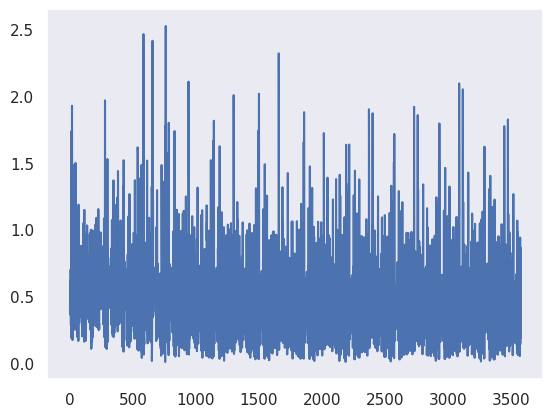

In [16]:
plt.plot(train_losses)

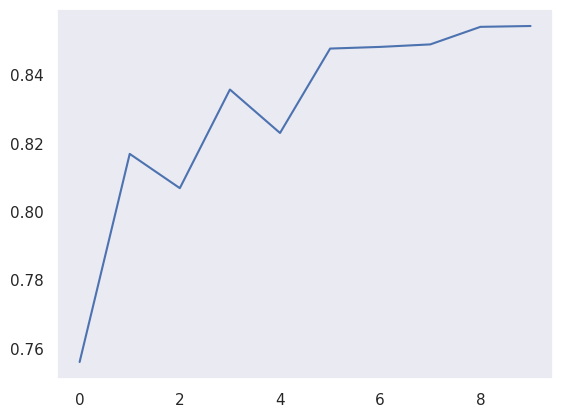

In [17]:
plt.plot(test_accuracy)

In [18]:
model_path = '../physio16k_fold4_m13_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [19]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [20]:
metrics, confusion_matrix = report_metrics(model)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3498/4064 (0.8607)
{'acc_detail': tensor([0.6072, 0.9402], device='cuda:0'),
 'acc_unweighted': tensor(0.7737, device='cuda:0'),
 'acc_weighted': tensor(0.8607, device='cuda:0'),
 'f1s': tensor(0.7934, device='cuda:0'),
 'f1s_detail': tensor([0.6755, 0.9113], device='cuda:0'),
 'precision_detail': tensor([0.7610, 0.8842], device='cuda:0'),
 'recall_detail': tensor([0.6072, 0.9402], device='cuda:0'),
 'rocauc': tensor([0.8663, 0.8663], device='cuda:0'),
 'uar': tensor(0.7737, device='cuda:0'),
 'wap': tensor(0.8548, device='cuda:0')}


tensor([[ 589,  381],
        [ 185, 2909]], device='cuda:0')

In [21]:
layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0036],
        [0.0075],
        [0.0117],
        [0.0162],
        [0.0211],
        [0.0264],
        [0.0322],
        [0.0384],
        [0.0451],
        [0.0524],
        [0.0603],
        [0.0688],
        [0.0780],
        [0.0880],
        [0.0988],
        [0.1105],
        [0.1231],
        [0.1368],
        [0.1516],
        [0.1676],
        [0.1849],
        [0.2036],
        [0.2239],
        [0.2458],
        [0.2696],
        [0.2952],
        [0.3230],
        [0.3531],
        [0.3856],
        [0.4208],
        [0.4588],
        [0.0000],
        [0.0054],
        [0.0111],
        [0.0171],
        [0.0235],
        [0.0303],
        [0.0375],
        [0.0452],
        [0.0534],
        [0.0620],
        [0.0712],
        [0.0809],
        [0.0912],
        [0.1022],
        [0.1138],
        [0.1261],
        [0.1392],
        [0.1531],
        [0.1679],
        [0.1835],
        [0.2002],
       

In [22]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-3.0194e-15],
        [-2.9283e-15],
        [-7.4449e-15],
        [ 1.0736e-16],
        [-6.1602e-16],
        [-3.2509e-17],
        [-6.8276e-17],
        [ 8.1279e-16],
        [ 4.5490e-16],
        [ 1.1257e-15],
        [ 4.2117e-15],
        [-8.5321e-16],
        [ 9.4910e-15],
        [-8.8211e-14],
        [-7.9795e-18],
        [ 4.4135e-15],
        [ 1.0346e-14],
        [ 3.0150e-16],
        [ 3.1964e-17],
        [-1.3876e-17],
        [ 1.4019e-15],
        [ 6.5936e-15],
        [ 2.2006e-16],
        [-1.5152e-17],
        [-2.2663e-15],
        [-8.7695e-15],
        [ 5.6741e-15],
        [ 3.4888e-15],
        [-1.1555e-14],
        [-2.4293e-13],
        [ 2.6817e-17],
        [ 0.0000e+00],
        [-7.8689e-16],
        [-1.6973e-16],
        [ 1.8998e-14],
        [ 5.5288e-13],
        [ 2.2646e-16],
        [-2.0344e-15],
        [-4.4315e-17],
        [-9.6671e-16],
        [ 1.8865e-15],
        [-3.1873e-16],
        [ 1

[None, None, None]

Time domain: Filters' shapes vary by frequency bins


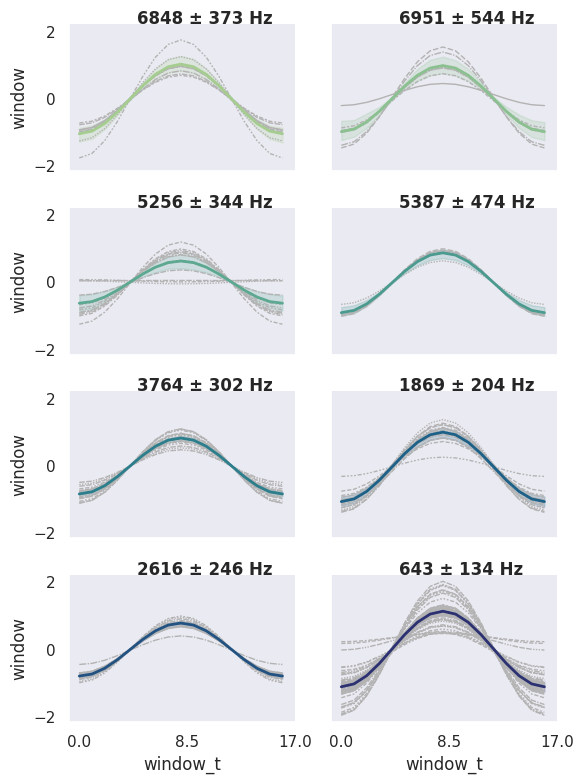

In [23]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


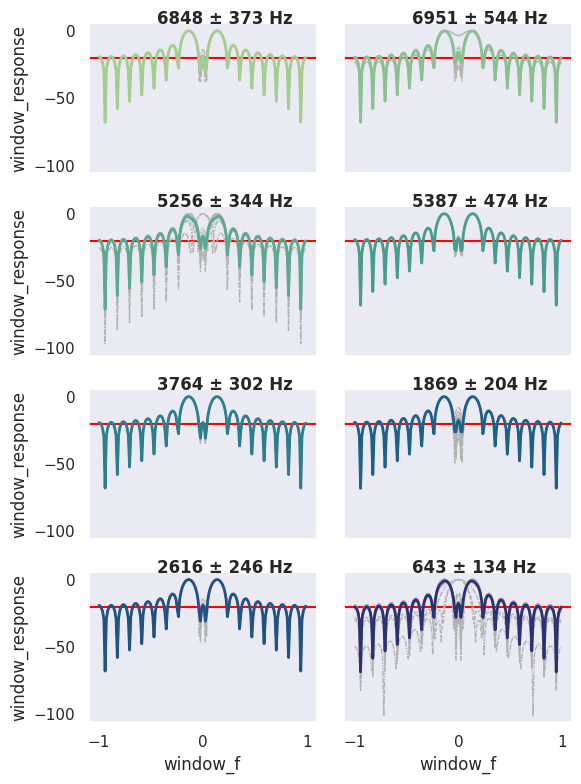

In [24]:
filtviz.visualize_filters(filter_domain='freq')

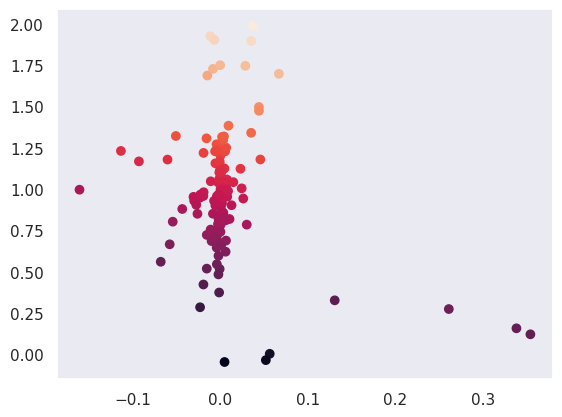

In [25]:
filtviz.visualize_window_params()

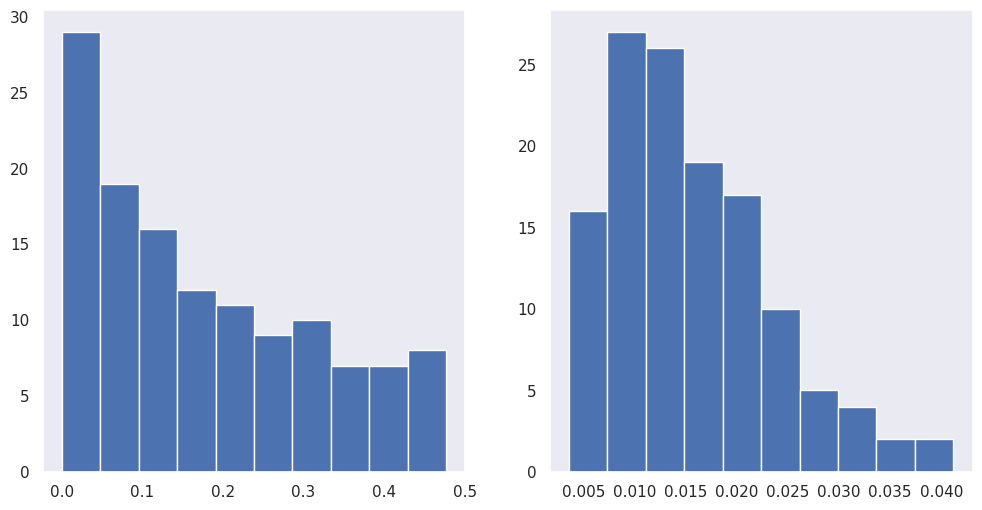

In [26]:
filtviz.visualize_bands()

In [27]:
layer2 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer2)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0384, 0.0384, 0.0384,  ..., 0.0384, 0.0384, 0.0384],
        ...,
        [0.2594, 0.2594, 0.2594,  ..., 0.2594, 0.2594, 0.2594],
        [0.3309, 0.3309, 0.3309,  ..., 0.3309, 0.3309, 0.3309],
        [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
        [0.0304, 0.0304, 0.0304,  ..., 0.0304, 0.0304, 0.0304],
        ...,
        [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
        [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
        [0.0892, 0.0892, 0.0892,  ..., 0.0892, 0.0892, 0.0892]],
       device='cuda:0', requires_grad=True))
('window_params', Parameter containing

downsample_factor: 8 => new_sample_rate: 2000
Time domain: Filters' shapes vary by frequency bins


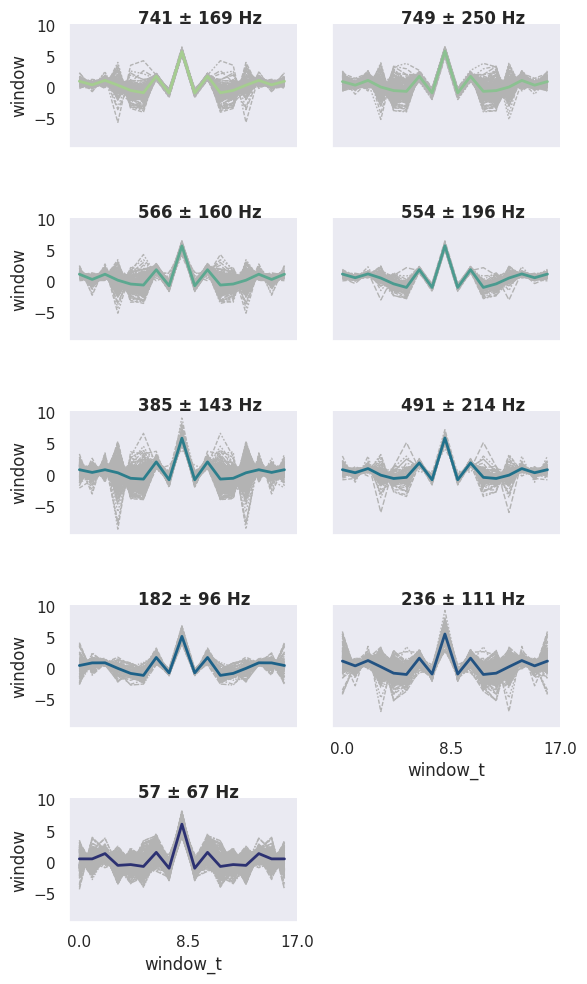

In [28]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


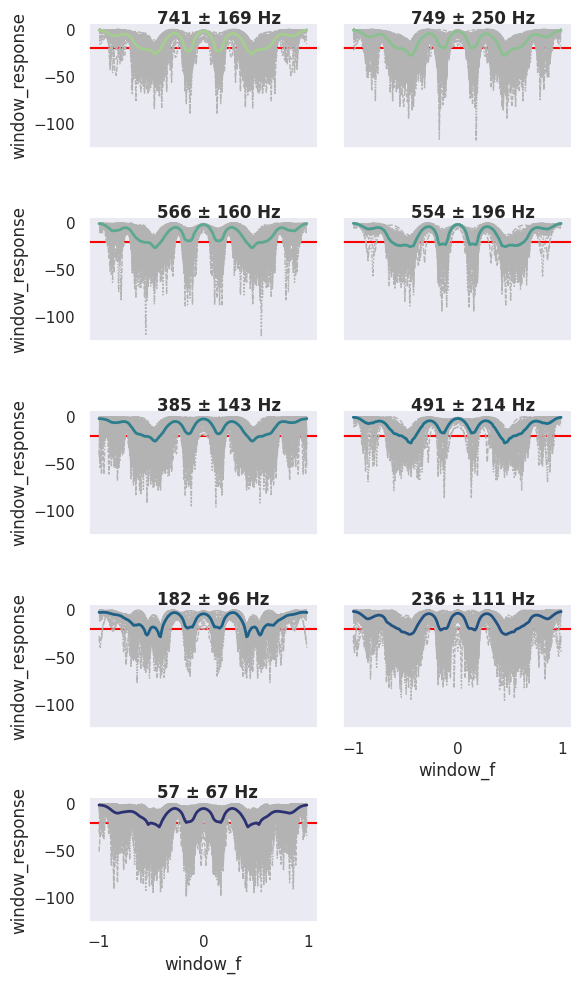

In [29]:
filtviz2.visualize_filters(filter_domain='freq')

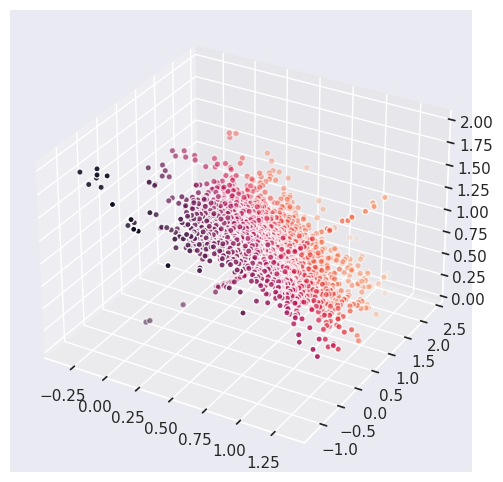

In [30]:
filtviz2.visualize_window_params()

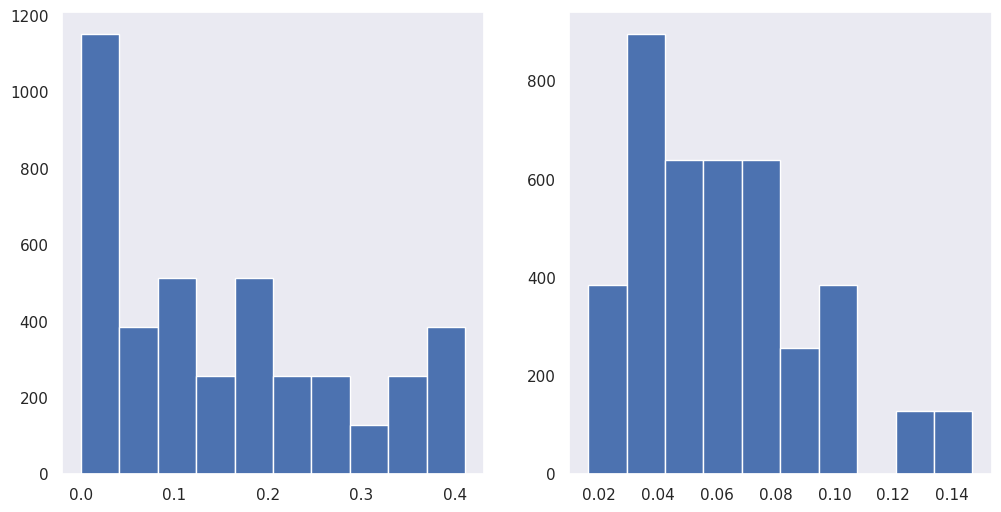

In [31]:
filtviz2.visualize_bands()

In [ ]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                        | 0.002061855670103093/50 [00:00<4:15:51, 307.04s/it]

Train Epoch: 11 [0/11481 (0%)]	Loss: 0.035022
Mem before-during-after: 32574976 4375923200 33818112


  0%|                                                                         | 0.08453608247422686/50 [00:18<3:01:14, 217.86s/it]

Train Epoch: 11 [1280/11481 (11%)]	Loss: 0.031619
Mem before-during-after: 33818112 4377249280 33818112


  0%|▏                                                                        | 0.16701030927835056/50 [00:36<3:05:44, 223.65s/it]

Train Epoch: 11 [2560/11481 (22%)]	Loss: 0.469037
Mem before-during-after: 33818112 4377249280 33818112


  0%|▎                                                                        | 0.24948453608247398/50 [00:54<3:02:35, 220.20s/it]

Train Epoch: 11 [3840/11481 (34%)]	Loss: 0.101915
Mem before-during-after: 33818112 4377249280 33818112


  1%|▍                                                                         | 0.3319587628865974/50 [01:11<3:05:02, 223.53s/it]

Train Epoch: 11 [5120/11481 (45%)]	Loss: 0.812607
Mem before-during-after: 33818112 4377249280 33818112


  1%|▌                                                                        | 0.41443298969072084/50 [01:29<3:06:11, 225.29s/it]

Train Epoch: 11 [6400/11481 (56%)]	Loss: 0.216746
Mem before-during-after: 33818112 4377249280 33818112


  1%|▋                                                                        | 0.49690721649484426/50 [01:48<3:06:34, 226.13s/it]

Train Epoch: 11 [7680/11481 (67%)]	Loss: 0.292134
Mem before-during-after: 33818112 4377249280 33818112


  1%|▊                                                                         | 0.5793814432989677/50 [02:07<3:35:02, 261.08s/it]

Train Epoch: 11 [8960/11481 (78%)]	Loss: 0.118647
Mem before-during-after: 33818112 4377249280 33818112


  1%|▉                                                                         | 0.6618556701030911/50 [02:28<3:31:28, 257.17s/it]

Train Epoch: 11 [10240/11481 (89%)]	Loss: 0.191726
Mem before-during-after: 33818112 4377249280 33818112


  2%|█▍                                                                        | 0.9999999999999971/50 [03:16<1:28:59, 108.96s/it]


Test Epoch: 11	Accuracy: 3519/4064 (86%)



  2%|█▍                                                                        | 1.0020618556701002/50 [03:17<2:00:36, 147.68s/it]

Train Epoch: 12 [0/11481 (0%)]	Loss: 0.021959
Mem before-during-after: 33810944 4377175552 33818112


  2%|█▌                                                                        | 1.0845360824742236/50 [03:37<3:26:23, 253.17s/it]

Train Epoch: 12 [1280/11481 (11%)]	Loss: 0.027427
Mem before-during-after: 33834496 4376692736 33834496


  2%|█▊                                                                         | 1.167010309278347/50 [03:58<3:35:45, 265.10s/it]

Train Epoch: 12 [2560/11481 (22%)]	Loss: 0.451688
Mem before-during-after: 33834496 4376692736 33834496


  2%|█▊                                                                        | 1.2494845360824705/50 [04:20<3:33:44, 263.06s/it]

Train Epoch: 12 [3840/11481 (34%)]	Loss: 0.023917
Mem before-during-after: 33834496 4376692736 33834496


  3%|█▉                                                                        | 1.3319587628865939/50 [04:41<3:34:03, 263.90s/it]

Train Epoch: 12 [5120/11481 (45%)]	Loss: 0.780939
Mem before-during-after: 33834496 4376692736 33834496


  3%|██                                                                        | 1.4144329896907173/50 [05:02<3:37:07, 268.14s/it]

Train Epoch: 12 [6400/11481 (56%)]	Loss: 0.230863
Mem before-during-after: 33834496 4376692736 33834496


  3%|██▏                                                                       | 1.4969072164948407/50 [05:23<3:31:06, 261.14s/it]

Train Epoch: 12 [7680/11481 (67%)]	Loss: 0.282637
Mem before-during-after: 33834496 4376692736 33834496


  3%|██▎                                                                       | 1.5793814432989641/50 [05:44<3:32:06, 262.82s/it]

Train Epoch: 12 [8960/11481 (78%)]	Loss: 0.112604
Mem before-during-after: 33834496 4376692736 33834496


  3%|██▍                                                                       | 1.6618556701030875/50 [06:05<3:26:52, 256.78s/it]

Train Epoch: 12 [10240/11481 (89%)]	Loss: 0.174105
Mem before-during-after: 33834496 4376692736 33834496


  4%|██▌                                                                       | 1.7587628865979326/50 [06:26<1:32:04, 114.51s/it]